Preprocessing

In [2]:
# avoid warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics.pairwise import cosine_similarity
import IPython.display as display
from PIL import Image

In [6]:
img_path = os.listdir('/home/jupyter/images/500/art')

In [ ]:
img_path[0]

In [7]:
img_tensors = []
for image_filename in img_path:
    img = Image.open(os.path.join('/home/jupyter/images/500/art', image_filename))
    img = img.resize((224,224))
    img_tensors.append(tf.convert_to_tensor(img))

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
resize_images_arr = np.array(img_tensors)

In [ ]:
resize_images_arr[:364,:,:,:].shape

In [ ]:
x_train_original = resize_images_arr[:364,:,:,:]
x_test_original = resize_images_arr[364:,:,:,:]

In [ ]:
# not sure if we need this
# Normalize for training
#x_train = x_train_original.astype('float32') / 255.
#x_test = x_test_original.astype('float32') / 255.
#x_train = x_train.reshape((len(x_train), 32, 32, 3))
#x_test = x_test.reshape((len(x_test), 32, 32, 3))
x_train = x_train_original
x_test = x_test_original

In [8]:
# Encoder
input_img = Input(shape=(224, 224, 3))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

FailedPreconditionError: {{function_node __wrapped____EagerConst_device_/job:localhost/replica:0/task:0/device:GPU:0}} Failed to allocate scratch buffer for device 0

In [77]:
# Autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# Training
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

In [81]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split = 0.3)
train_generator = train_datagen.flow_from_directory(
        '/home/jupyter/images/500',
        target_size=(224, 224),
        batch_size= 32,
        class_mode='input',
        subset = 'training',
        color_mode = 'rgb' )
validation_generator = train_datagen.flow_from_directory(
        '/home/jupyter/images/500',
        target_size=(224, 224),
        batch_size=32,
        class_mode='input',
        subset = 'validation',
        color_mode = 'rgb')
autoencoder.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=20)

Found 364 images belonging to 1 classes.
Found 156 images belonging to 1 classes.
Epoch 1/10
12/12 [==============================] - 21s 2s/step - loss: 0.5686
Epoch 2/10
12/12 [==============================] - 20s 2s/step - loss: 0.5659
Epoch 3/10
12/12 [==============================] - 21s 2s/step - loss: 0.5638
Epoch 4/10
12/12 [==============================] - 21s 2s/step - loss: 0.5633
Epoch 5/10
12/12 [==============================] - 21s 2s/step - loss: 0.5628
Epoch 6/10
12/12 [==============================] - 21s 2s/step - loss: 0.5619
Epoch 7/10
12/12 [==============================] - 20s 2s/step - loss: 0.5604
Epoch 8/10
12/12 [==============================] - 21s 2s/step - loss: 0.5596
Epoch 9/10
12/12 [==============================] - 21s 2s/step - loss: 0.5596
Epoch 10/10
12/12 [==============================] - 20s 2s/step - loss: 0.5587


In [82]:
# Extracting image representation using the encoder
encoder = Model(input_img, encoded)

# Suppose we want to compare two images
image1_representation = encoder.predict(x_test[0:1])
image2_representation = encoder.predict(x_test[1:2])

# Compute similarity using cosine similarity
similarity = cosine_similarity(image1_representation.reshape(1, -1), image2_representation.reshape(1, -1))

print(f"Similarity between the two images: {similarity[0][0]}")

1/1 [==============================] - 0s 20ms/step
Similarity between the two images: 0.9668879508972168


5/5 [==============================] - 0s 5ms/step
Indices of top 5 similar images: [139  21  74  57  54]


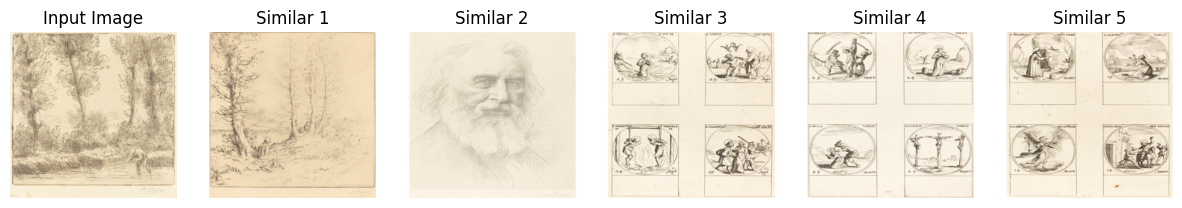

In [86]:

def get_top_5_similar(input_image, dataset):
    input_representation = encoder.predict(input_image)
    
    # Compute cosine similarities between the input image and all images in the dataset
    similarities = cosine_similarity(input_representation.reshape(1, -1), 
                                     encoder.predict(dataset).reshape(len(dataset), -1))
    
    # Get indices of the top 5 similar images
    top_5_indices = np.argsort(similarities[0])[-6:-1][::-1]  # -6 because the most similar one will be the image itself
    
    return top_5_indices

# Example of getting top 5 similar images to x_test[0]
input_image = x_test[50:51]
similar_indices = get_top_5_similar(input_image, x_test)
print(f"Indices of top 5 similar images: {similar_indices}")

# Display the input image and its 5 most similar images
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 6, figsize=(15, 5))
ax[0].imshow(input_image[0])
ax[0].set_title("Input Image")
ax[0].axis('off')

for i, index in enumerate(similar_indices, 1):
    ax[i].imshow(x_test[index])
    ax[i].set_title(f"Similar {i}")
    ax[i].axis('off')

plt.show()